In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn settings
sns.set_theme()
sns.set_context("poster", font_scale=1.4)

from mcmc import metropolis_hastings

from scipy.special import factorial
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
data_filepath = './../archive/auto-mpg.data'

df = pd.read_csv(data_filepath, delim_whitespace=True, header=None, 
                 names=['mpg', 'cylinders', 'displacement', 'horsepower', 
                        'weight', 'acceleration', 'model_year', 'origin', 'car_name'])

In [3]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.00,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.00,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.00,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.00,2625.0,18.6,82,1,ford ranger


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [5]:
df[df['horsepower'] == '?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
32,25.0,4,98.0,?,2046.0,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875.0,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835.0,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905.0,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320.0,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035.0,20.5,82,1,amc concord dl


In [6]:
df = df.replace('?', None)
df.dropna(inplace=True)
df.drop(['car_name'], axis=1, inplace=True)
df['horsepower'] = df['horsepower'].astype(np.float64)

In [7]:
min_max_scaler = MinMaxScaler()
df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']] = min_max_scaler.fit_transform(
    df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']])

In [8]:
df['mpg'] = df['mpg'].round(0).astype(int)

In [9]:
data = df.to_numpy()
data

array([[18.        ,  1.        ,  0.61757106, ...,  0.23809524,
         0.        ,  0.        ],
       [15.        ,  1.        ,  0.72868217, ...,  0.20833333,
         0.        ,  0.        ],
       [18.        ,  1.        ,  0.64599483, ...,  0.17857143,
         0.        ,  0.        ],
       ...,
       [32.        ,  0.2       ,  0.17312661, ...,  0.21428571,
         1.        ,  0.        ],
       [28.        ,  0.2       ,  0.13436693, ...,  0.63095238,
         1.        ,  0.        ],
       [31.        ,  0.2       ,  0.13178295, ...,  0.67857143,
         1.        ,  0.        ]])

In [72]:
def gaussian_proposals(beta, bias_sigma, sigma):
    sigmas = [sigma]*(len(beta)-1)
    sigmas.insert(0, bias_sigma)
    return np.random.normal(beta, sigmas, beta.shape)

def log_prior(beta):
    """
    beta[0] = intercept
    beta[1] = cylinders
    beta[2] = displacement
    beta[3] = horsepower
    beta[4] = weight
    beta[5] = acceleration
    beta[6] = model_year
    beta[7] = origin
    """
    bias_sigma = 0.5
    sigma = 0.25
    
    prior_beta_bias = -np.log(bias_sigma * np.sqrt(2*np.pi)) - (beta[0]**2) / (2*bias_sigma**2)
    prior_beta_neg = -np.log(sigma * np.sqrt(2*np.pi)) - ((beta[1:5] + 0.25)**2) / (2*sigma**2)
    prior_beta_pos = -np.log(sigma * np.sqrt(2*np.pi)) - ((beta[5:] - 0.25)**2) / (2*sigma**2)
    
    return prior_beta_bias + np.sum(prior_beta_neg) + np.sum(prior_beta_pos)

def log_likelihood(beta, data):
    
    n = len(data)
    
    X = np.append(np.ones((n, 1)), data[:, 1:], axis=1)  # add bias column
    y = data[:, 0].astype(int)
    lam = np.exp(np.matmul(X, beta))
    
    likelihoods = y * np.log(lam) - lam - np.log(factorial(y))
    
    return np.sum(likelihoods)

In [73]:
X_train, X_test, _, _ = train_test_split(data, data[:, 0], test_size=0.2)

In [74]:
beta_init = np.array([0, -0.2, -0.2, -0.2, -0.2, 0.2, 0.2, 0.2])
accepted, rejected, a_rate = metropolis_hastings(beta_init, gaussian_proposals, log_prior, log_likelihood, X_train, 
                                                 proposal_kwargs={'bias_sigma': 0.025, 'sigma': 0.025}, samples=100_000, burn_in=0.25)

In [75]:
a_rate

0.2901228196924347

In [76]:
accepted.shape, rejected.shape

((16866, 8), (58134, 8))

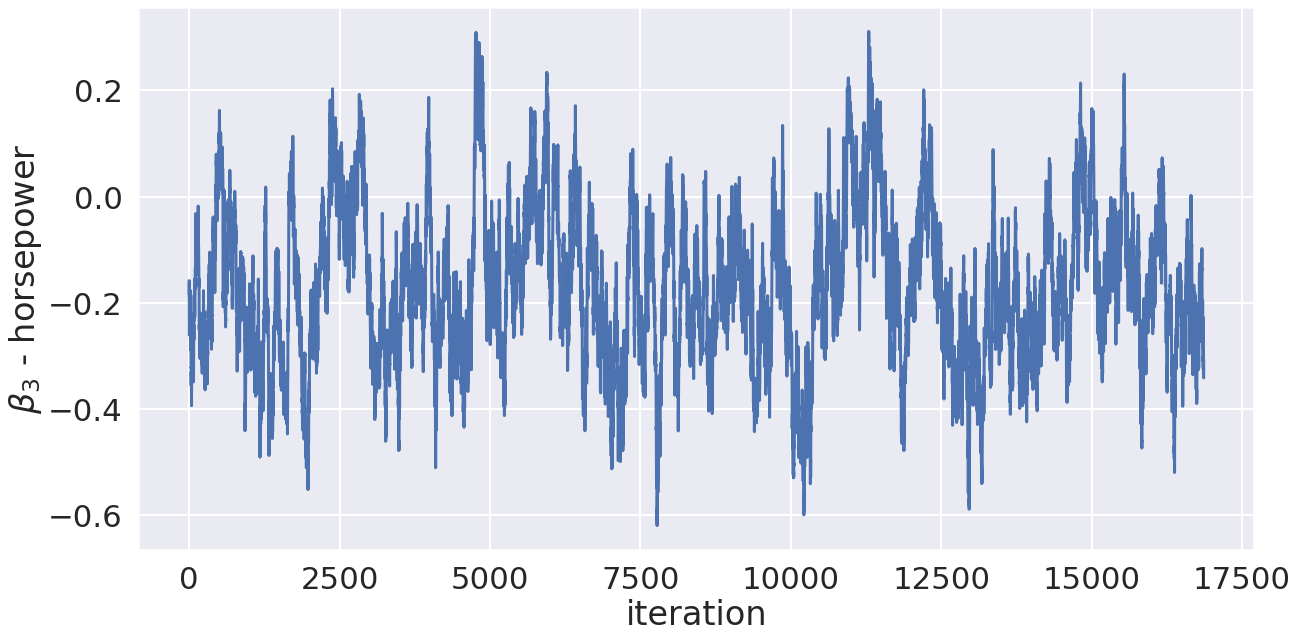

In [77]:
n = accepted.shape[0]
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(range(n), accepted[:,3])
plt.xlabel('iteration')
plt.ylabel(r'$\beta_{3}$ - horsepower')
plt.show()

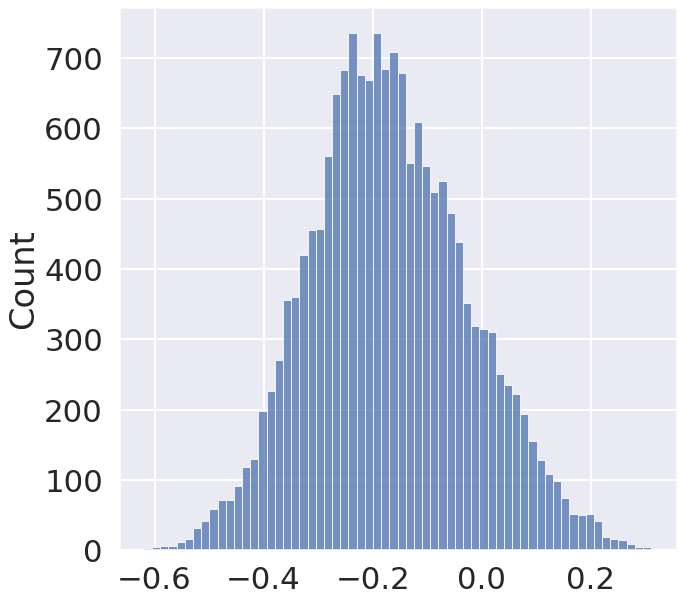

In [78]:
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(data=accepted[:,3])
plt.show()

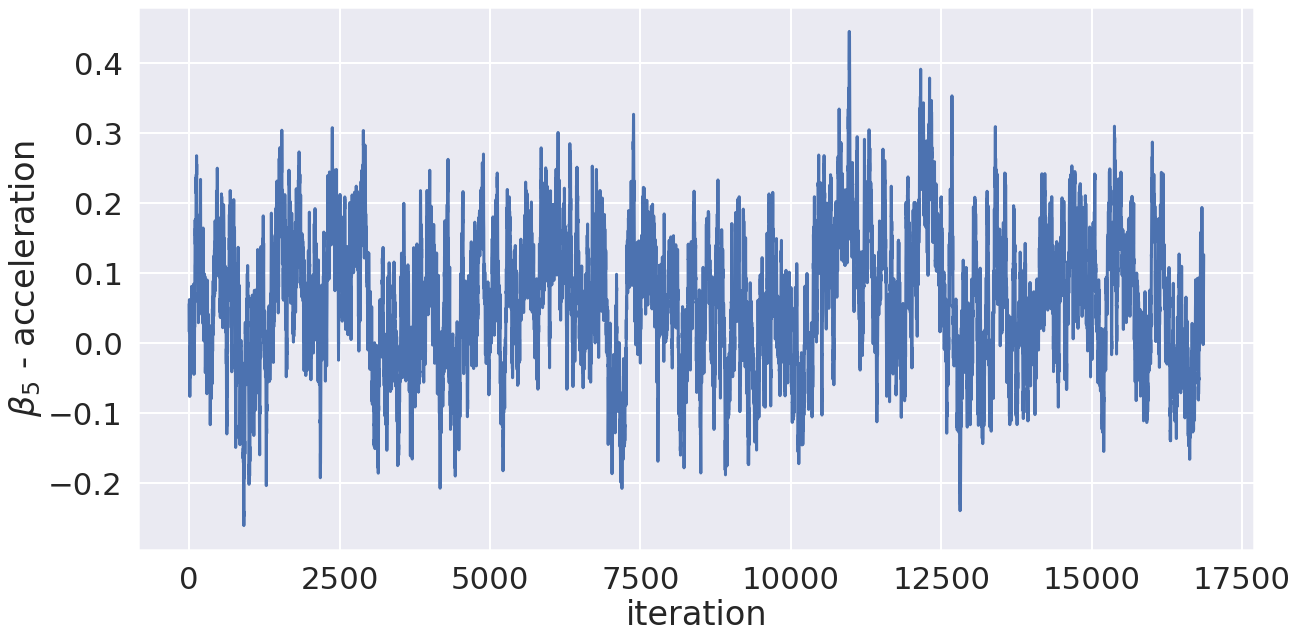

In [79]:
n = accepted.shape[0]
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(range(n), accepted[:,5])
plt.xlabel('iteration')
plt.ylabel(r'$\beta_{5}$ - acceleration')
plt.show()

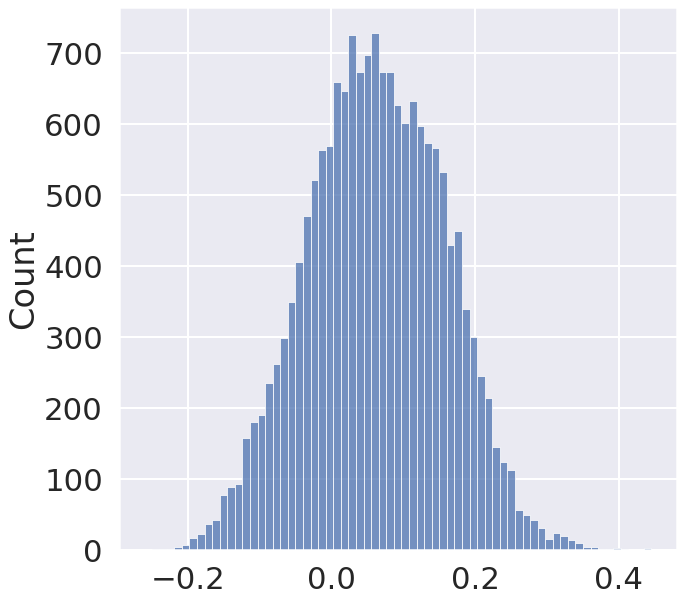

In [80]:
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(data=accepted[:,5])
plt.show()

In [81]:
beta = np.mean(accepted, axis=0)

In [82]:
beta

array([ 3.24929967, -0.04256108, -0.0813463 , -0.16869637, -0.73655661,
        0.06204618,  0.37743091,  0.07920751])

In [83]:
n = len(X_train)
X = np.append(np.ones((n, 1)), X_train[:, 1:], axis=1)  # add bias column
y = X_train[:, 0].astype(int)
lam = np.exp(np.matmul(X, beta))

In [84]:
r2_score(y, lam)

0.867580609210456

In [85]:
mean_squared_error(y, lam)

8.327001237379642

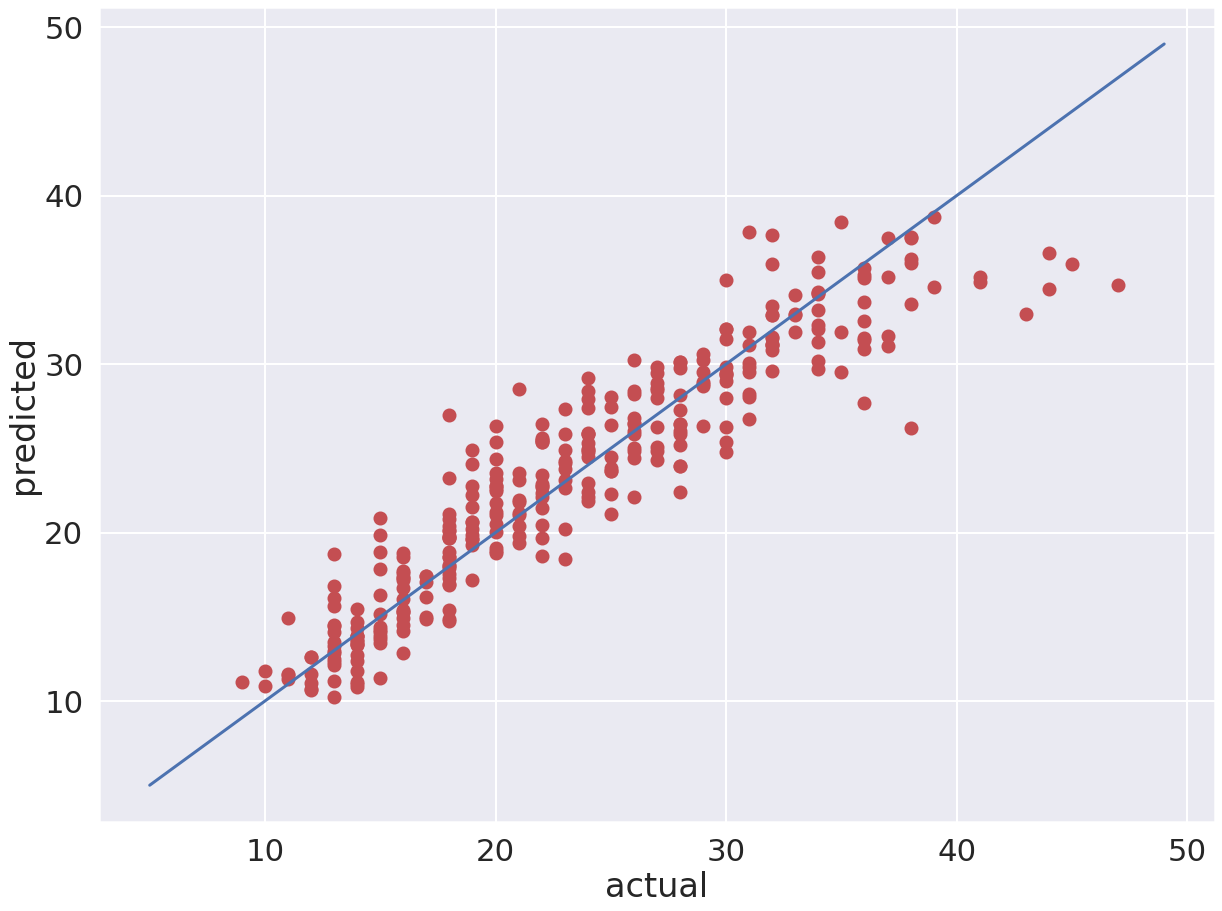

In [86]:
fig, ax = plt.subplots(figsize=(20,15))
plt.plot(range(5, 50), range(5, 50))
plt.scatter(y, lam, c='r')
ax.set_xlabel('actual')
ax.set_ylabel('predicted')
#ax.set_title("Figure 1: Linear Polynomial with Gaussian Noise ($m = 3, b = 2, \sigma = 1$)\n")
plt.show()

In [88]:
n = len(X_test)
X = np.append(np.ones((n, 1)), X_test[:, 1:], axis=1)  # add bias column
y = X_test[:, 0].astype(int)
lam = np.exp(np.matmul(X, beta))

In [89]:
r2_score(y, lam)

0.8058724880634204

In [90]:
mean_squared_error(y, lam)

10.339716604522073

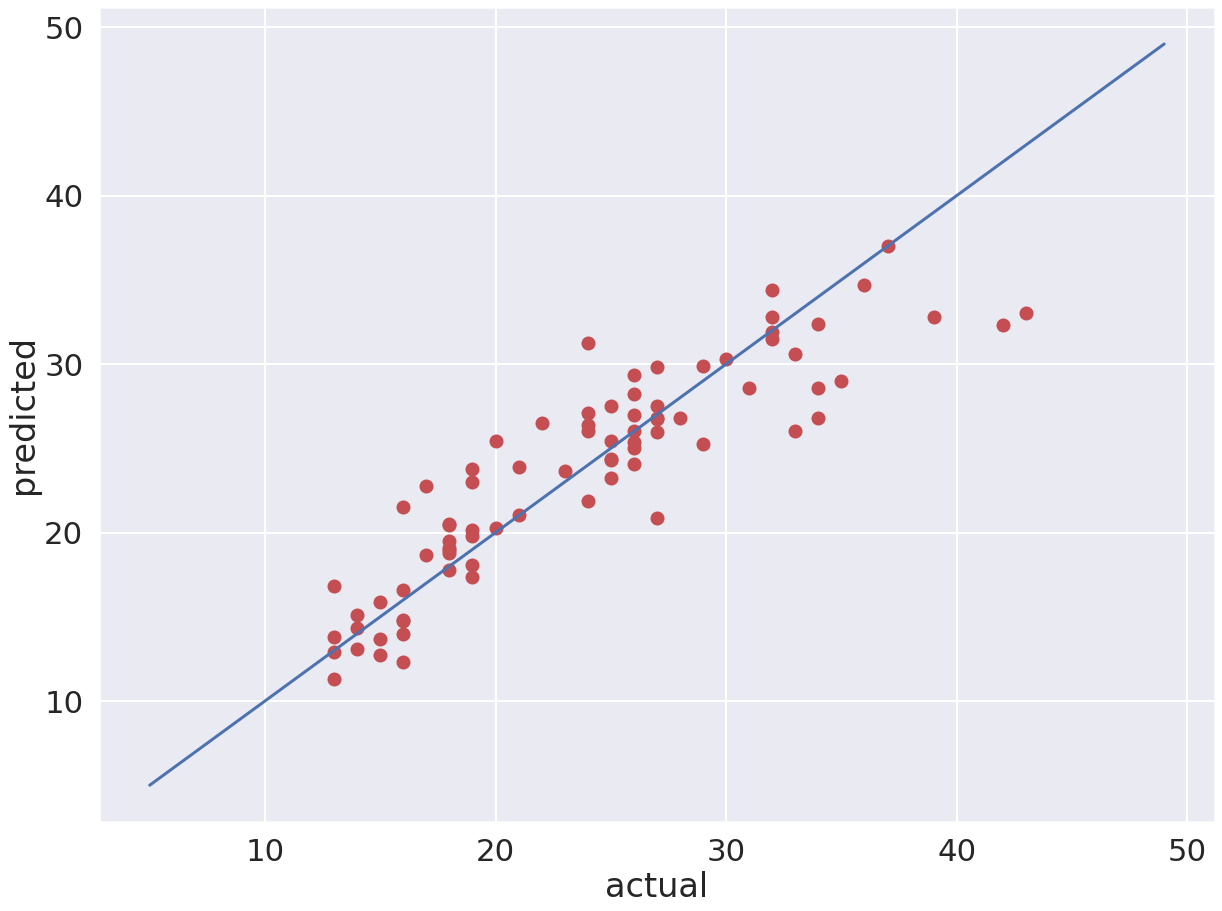

In [94]:
fig, ax = plt.subplots(figsize=(20,15))
plt.plot(range(5, 50), range(5, 50))
plt.scatter(y, lam, c='r')
ax.set_xlabel('actual')
ax.set_ylabel('predicted')
#ax.set_title("Figure 1: Linear Polynomial with Gaussian Noise ($m = 3, b = 2, \sigma = 1$)\n")
plt.show()